## Algorithmic Fairness
3 types of bias Mitigation Strategies for ML Models

**Pre-processing**:
Adjust the feature space to be uncorrelated with the sensitive attribute. (Modify ***data*** before training).

**Pros:** Generally agnostic to what we do with the new feature space in downstream applications. After pre-processing, any deterministic training process on the new space will also satisfy fairness criteria.

**Cons:** The interpretation of features is no longer clear. We may need to repair feature values for multiple protected variables (e.g. gender, race, country of origin). After so many shifts of a feature’s distribution, it loses its interpretation.

**Example:** ***Learning fair representations.***


**In-processing**:
Work the constraint into the optimization process that constructs a classifier from training data. (Modify ***algorithm*** that is trained)

**Pros:** Can lead to highest utility since we get to optimize the classifier with fair criterion.

**Cons:** Need access to the raw data and training pipeline.

**Example:** ***Prejudice removal via Regularization*** adds a discrimination-aware regularization term to the learning objective.

**Post-processing**:
Adjust a learned classifier so as to be uncorrelated with the sensitive attribute.(Modify ***predictions*** of trained model).

**Pros:** Do not require access to the training process and are thus suitable for run-time environments.

**Cons:** Often require to have information on protected variables at the time of prediction. However, due to legal or privacy reasons, this type of information is only available during training. 

**Example:** Equalized odds post-processing changed target variables with certain probabilities (via linear programming) to optimize equalized odds.

### Learning fair representations algorithm for bias mitigation
Learning fair representations [1] is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes. We will see how to use this algorithm for learning representations that encourage individual fairness and apply them on the Adult dataset.

References:

[1] R. Zemel, Y. Wu, K. Swersky, T. Pitassi, and C. Dwork,  "Learning Fair Representations." 
International Conference on Machine Learning, 2013.

**Notation:**
- $X$: the entire data set of individuals. Each $x \in X$ is a vector of length $D$ where each component of the vector describes some attribute of the person.
- $X_0$: the training set of individuals.
- $S$: sensitive attribute (binary). ($S = 1$ means the given individual is from the protected set.)
- $X^+,X^-\subset X;$ $X_0^+,X_0^-\subset X_0$: The subset of individuals that are members from the protected set($S = 1$).
- $Z$: a multinomial random variable, where each of the $K$ values represents one of the intermediate set of ”prototypes”. Associated with each prototype is a vector $v_k$ in the same space as the individuals $x$. (To encode $X$)
- $Y$: the binary random variable representing the
classification decision for an individual.
- $f: X \to Y$: the desired classification function.
- $d$: a distance measure on X

**Goal:** Given ,learn a set Z such that 

- the mapping from $X_0$ to $Z$ satisfies statistical parity;
- the mapping to $Z$-space retains information in $X$ (except for membership in the protected set);
- the induced mapping from $X$ to $Y$ (by first mapping each $x$ probabilistically to $Z$-space, and then mapping $Z$ to $Y$) is close to $f$.

we can formulate the 3 goals in learning objective.

**Formulation**:

Want to ensure statistical parity(group fairness):

$$
P(Z=k|x^+ \in X^+) = P(Z=k|x^- \in X^-)\ \ \forall k
$$

Define $M_{n,k}$ as the probability that $x_n$ maps to $v_k$

$$
M_{n,k} = P(Z=k|x_n)\ \ \forall n,k
$$

Estimate the statistical parity using the training data as:
$$
M_k^+ \triangleq \mathbb{E}_{x \in X^+}P(Z=k|x); M_k^- \triangleq \mathbb{E}_{x \in X^-}P(Z=k|x)
$$

- loss function to constrain the mapping from $X_0$ to $Z$ satisfies statistical parity:

$$
L_z = \sum_{k=1}^K |M_k^+-M_k^-|.
$$

- loss function to constrain the mapping to Z to be a good description of X:
$$
L_x = \sum_{n=1}^N(x_n-\hat{x}_n)^2,
$$
where $\hat{x}_n = \sum_{k=1}^K M_{n,k}v_k$ is the reconstructions of $x_n$ from $Z$.

- loss function to constrain the prediction of $y$ to be accurate:

$$
L_y = \sum_{n=1}^N-y_n\log \hat{y}_n-(1-y_n)\log(1-\hat{y}_n),
$$
where $\hat{y}_n = \sum_{k=1}^K M_{n,k}w_k$ is the prediction of $y_n$ from $Z$.

The learning system minimizes
$$
\min_{\{v_k\}_k, w} L \triangleq A_z \cdot L_z + A_x \cdot L_x + A_y \cdot L_y,
$$
where $A_x, A_y, A_z$ are hyper-parameters governing the trade-off between the system desiderata(3 goals).

The following implementation is based on AIF360 package:https://github.com/Trusted-AI/AIF360

In [22]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.lfr import LFR

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import numpy as np

from common_utils import compute_metrics

#### Load dataset and set options

In [2]:
# Get the dataset and split into train and test
dataset_orig = load_preproc_data_adult()
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

#### Clean up training data

In [3]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex', 'race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


#### Metric for original training data

In [4]:
# Metric for the original dataset
privileged_groups = [{'sex': 1.0}]
unprivileged_groups = [{'sex': 0.0}]

metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())


#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.194408


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.194798


#### Train with and transform the original training data

In [5]:
scale_orig = StandardScaler()
dataset_orig_train.features = scale_orig.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = scale_orig.transform(dataset_orig_test.features)

Ensure fairness between privileged groups and unprivileged groups

In [29]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

#### learning fair representation

In [6]:
# Input recontruction quality - Ax
# Fairness constraint - Az
# Output prediction error - Ay
    
TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
         k=10, Ax=0.1, Ay=1.0, Az=2.0,
         verbose=1
        )
TR = TR.fit(dataset_orig_train, maxiter=150000, maxfun=150000)

step: 0, loss: 0.935283741288489, L_x: 2.6263362868428324,  L_y: 0.6499386776251032,  L_z: 0.011355717489551293
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          190     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35284D-01    |proj g|=  1.05730D-01
step: 250, loss: 0.8719518104173174, L_x: 2.623884324254414,  L_y: 0.5876625909416852,  L_z: 0.010950393525095413

At iterate    1    f=  8.71952D-01    |proj g|=  7.01313D-02
step: 500, loss: 0.8233765782722775, L_x: 2.6109136298634255,  L_y: 0.5435845154230858,  L_z: 0.009350349931424595

At iterate    2    f=  8.23377D-01    |proj g|=  3.01234D-02
step: 750, loss: 0.8178535766083774, L_x: 2.6043310601656,  L_y: 0.5402930048062987,  L_z: 0.008563732892759381

At iterate    3    f=  8.17854D-01    |proj g|=  2.11383D-02

At iterate    4    f=  7.94400D-01    |proj g|=  2.43791D-02
step: 1000, loss: 0.7868211343640047, L_x: 2.529721040230805,  L_y: 0.

In [7]:
# Transform training data and align features
dataset_transf_train = TR.transform(dataset_orig_train)
dataset_transf_test = TR.transform(dataset_orig_test)

* Precision: The proportion of true positives (TP) out of all positive predictions (TP + FP).
* Recall: The proportion of true positives (TP) out of all actual positives (TP + FN).
* F1-score: The harmonic mean of precision and recall, which provides a single score that balances the trade-off between precision and recall.
* Support: The number of instances of each class in the true labels.

In [13]:
print(classification_report(dataset_orig_train.labels, dataset_transf_train.labels))

              precision    recall  f1-score   support

         0.0       0.81      0.93      0.86     26076
         1.0       0.56      0.29      0.39      8113

    accuracy                           0.78     34189
   macro avg       0.69      0.61      0.62     34189
weighted avg       0.75      0.78      0.75     34189



In [8]:
print(classification_report(dataset_orig_test.labels, dataset_transf_test.labels))

              precision    recall  f1-score   support

         0.0       0.80      0.93      0.86     11079
         1.0       0.58      0.30      0.39      3574

    accuracy                           0.78     14653
   macro avg       0.69      0.61      0.63     14653
weighted avg       0.75      0.78      0.75     14653



In [9]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())
metric_transf_test = BinaryLabelDatasetMetric(dataset_transf_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Transformed test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_test.mean_difference())


#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.019441


#### Transformed test dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.021654


#### Predictions from transformed testing data
The goal in the UCI Adult dataset is to predict whether an individual earns high income(Y=1) or low income (Y=0). We define someone has high income when score>some threshold.

The choice of the threshold is subjective and potentially limits the external validity of UCI Adult as a benchmark for algorithmic fairness. We see what will happen when varying the threshold.

In [26]:
from common_utils import compute_metrics

bal_acc_transf = []
disp_imp_arr_transf = []

class_thresh_arr = np.linspace(0.01, 0.63, 100)

dataset_transf_test_new = dataset_orig_test.copy(deepcopy=True)
dataset_transf_test_new.scores = dataset_transf_test.scores
print(np.max(dataset_transf_test.scores))

for thresh in class_thresh_arr:
    
    fav_inds = dataset_transf_test_new.scores > thresh
    dataset_transf_test_new.labels[fav_inds] = 1.0
    dataset_transf_test_new.labels[~fav_inds] = 0.0
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_new, 
                                      unprivileged_groups, privileged_groups,
                                      disp = False)

    bal_acc_transf.append(metric_test_aft["Balanced accuracy"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

0.6368881662963097


/Users/zoeyzhu/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)


Statistical Parity/Demographic Parity:
$$ 
Pr(\hat{Y} = 1 | D = \text{unprivileged}) - Pr(\hat{Y} = 1 | D = \text{privileged}),
$$
when prediction is fair, stats=istical parity should be close to 0.

Disparate Impact:
$$
\frac{Pr(\hat{Y} = 1 | D = \text{unprivileged})}{Pr(\hat{Y} = 1 | D = \text{privileged})},
$$
when prediction is fair, disparate impact should be close to 1.

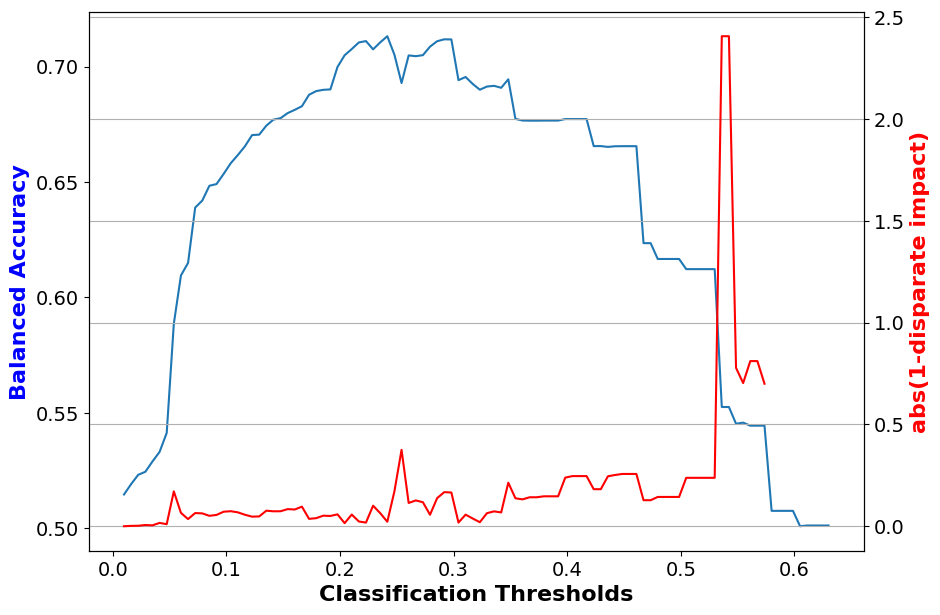

In [28]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
#ax2.plot(class_thresh_arr, disp_imp_arr_transf, color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.

#### Individual fairness metrics
Compare a model’s classification prediction of a given data item x to its k-nearest neighbors, kNN(x):
$$
1-\frac{1}{N k} \sum_n\sum_{j \in k N N\left(\mathbf{x}_n\right)}\left|\hat{y}_n-\hat{y}_j\right|
$$

In [12]:
print("Consistency of labels in transformed training dataset= %f" %metric_transf_train.consistency())
print("Consistency of labels in original training dataset= %f" %metric_orig_train.consistency())
print("Consistency of labels in transformed test dataset= %f" %metric_transf_test.consistency())
print("Consistency of labels in original test dataset= %f" %metric_orig_test.consistency())

#### Individual fairness metrics

Consistency of labels in transformed training dataset= 1.000000
Consistency of labels in original training dataset= 0.738559
Consistency of labels in transformed test dataset= 1.000000
Consistency of labels in original test dataset= 0.749212


Individual fairness requires transformed dataset consistency to be greater than original dataset.